<hr style="border:2px solid gray"> </hr>

# Homework 1 - Traveling Salesman Problem

## Example Code

### Algorithm 1: Greedy

### Author: Wangduk Seo (CAU AI Lab)
<hr style="border:2px solid gray"> </hr>

# Step 0. Importing packages and Global Settings

---------------------------------------------------------------
## (Optional) For Colab

In [ ]:
# from google.colab import drive
# import os, sys
# drive.mount('gdrive', force_remount=True)

---------------------------------------------------------------

In [5]:
# package list
import numpy as np
import sys
from sklearn.metrics.pairwise import euclidean_distances
import matplotlib.pyplot as plt
import time

# Global Variables
# Hill Climbing
SUB_ITERATIONS = 2000 # Iteration of 2-opt search in each evaluation
MAX_EVALUATION = 20 # Max hill climbing iterations

# Plot Settings
PLOT_MODE = True # Draw Route
PLT_INTERVAL = 100 # Draw Route every 100 iterations
plt.ion()

# First City Index
FIRST_IDX = 0

In [6]:
file_path = 'data3.txt'

# Step 1. Data Loading

In [7]:
def fileloader():
    #     Data Format
    #     ---------------------------------------------------------
    #     NAME : pia3056
    #     COMMENT : Bonn VLSI data set with 3056 points
    #     COMMENT : Uni Bonn, Research Institute for Discrete Math
    #     COMMENT : Contributed by Andre Rohe
    #     TYPE : TSP
    #     DIMENSION : 3056 -----------------------------|
    #     EDGE_WEIGHT_TYPE : EUC_2D                     |
    #     NODE_COORD_SECTION                            |
    #     1 0 11 (2 dimentional coordinate of city)     |
    #     2 0 115                                       |
    #     ...                                           |
    #     ...(Total 3056 nodes)<------------------------|
    #     EOF
    #     ---------------------------------------------------------
    with open(file_path, "r") as file:
        file_str = file.readlines()

    # Get the coordinates of cities
    coord_str = file_str[8:-1]  # first city string to last city string (EOF 전까지)
    coord_list = np.zeros((len(coord_str), 2))
    for idx, item in enumerate(coord_str):
        items = item.split()
        coord_list[idx, 0], coord_list[idx, 1] = int(items[1]), int(items[2])

    return coord_list

# Step 2. Searching a path
## Algorithm 1. Greedy Algorithm

In [8]:
def path_cost(path_map, path):
    # The array of cost between cities in the path
    cnt_cities = path_map.shape[0]
    cost_arr = np.zeros(cnt_cities)
    for i in range(cnt_cities):
        cost_arr[i] = path_map[path[i], path[i+1]]

    return cost_arr

def greedy(coord_list):
    cnt_cities = len(coord_list)
    # Initialize path and insert first city index to the first and last elements
#     best_path = np.zeros(cnt_cities + 1, dtype=np.int32)
    best_path = np.full(cnt_cities+1, -1, dtype=np.int32)
    # random select first city
    FIRST_IDX = np.random.randint(cnt_cities+1, size=1)[0]
#     print(FIRST_IDX)
    best_path[0], best_path[-1] = FIRST_IDX, FIRST_IDX

    # Euclidean distance map between cities
    path_map = euclidean_distances(coord_list, coord_list)

    cities_tovisit = np.ones((cnt_cities), dtype=np.bool_)
    cities_tovisit[FIRST_IDX] = False

    # Iteratively Connect nearest cities
    for i in range(1, cnt_cities):
        # jump already selected path
        if best_path[i] != -1:
            continue
            
        start_idx = best_path[i - 1]
        distance_from_start = path_map[start_idx, :]
        nearest_list = np.argsort(distance_from_start)
        
        # next city candidates        
        candidate_cities = []
        # set candidate number to 0.5% of number of cities
        CANDIDATE_NUMBER = cnt_cities // 200 + 1
        
        for idx in range(len(nearest_list)):
            # check the nearest city is visited
            if cities_tovisit[nearest_list[idx]]:
                nearest_city = nearest_list[idx]
                # add to candidate city list
                candidate_cities.append(nearest_city)
                if len(candidate_cities)==CANDIDATE_NUMBER:
                    break
        
        # set lookahead number to 5% of number of cities
        LOOKAHEAD_NUMBER = cnt_cities // 20 + 1
        # lookahead cost list for candidate cities
        candidate_cost = []
        candidate_path = []
        candidate_cities_tovisit = []
        # greedy algorithm for candidate cities
        for candidate_city in candidate_cities:
            # initialize lookahead cost to distance from current city to candidate city
            lookahead_cost = path_map[start_idx, candidate_city]
            # copy arrays
            lookahead_path = best_path.copy()
            lookahead_cities_tovisit = cities_tovisit.copy()
            # visit candidate city
            lookahead_path[i] = candidate_city
            lookahead_cities_tovisit[candidate_city] = False
            # perform greedy for lookahead 
            for j in range(i+1, min(i+LOOKAHEAD_NUMBER, cnt_cities)):
                candidate_start_idx = lookahead_path[j-1]
                distance_from_candidate = path_map[candidate_start_idx, :]
                nearest_list_candidate = np.argsort(distance_from_candidate)
                for c_idx in range(len(nearest_list_candidate)):
                    if lookahead_cities_tovisit[nearest_list_candidate[c_idx]]:
                        candidate_nearest_city = nearest_list_candidate[c_idx]
                        break
                lookahead_cities_tovisit[candidate_nearest_city] = False
                lookahead_path[j] = candidate_nearest_city
                # update lookahead cost
                lookahead_cost += path_map[candidate_start_idx, candidate_nearest_city]
            # add lookahead cost
            candidate_cost.append(lookahead_cost)
            candidate_path.append(lookahead_path)
            candidate_cities_tovisit.append(lookahead_cities_tovisit)
        
#         print(start_idx, candidate_cities)
        # select minimum lookahead cost
        next_path_candidate_idx_sort = np.argsort(candidate_cost)
        # select next path
        cities_tovisit = candidate_cities_tovisit[next_path_candidate_idx_sort[0]].copy()
        best_path = candidate_path[next_path_candidate_idx_sort[0]].copy()
        
        
    cost_arr = path_cost(path_map, best_path)
    best_cost = cost_arr.sum()
    
    # Draw Route
    if PLOT_MODE:
        plt.close()
        figure, ax = plt.subplots()
        plt.scatter(coord_list[:, 0], coord_list[:, 1], c='red', s=10)
        plt.title('City Route')
        coord_path = coord_list
        coord_path = np.append(coord_path, coord_path[best_path[0], :].reshape(1, 2), axis=0)
        coord_path[:, :] = coord_path[best_path, :]
        lines, = ax.plot(coord_path[:, 0], coord_path[:, 1], 'k--')
        figure.canvas.draw()
        figure.canvas.flush_events()
        plt.show()
    
    return best_path, best_cost, cost_arr

# Main

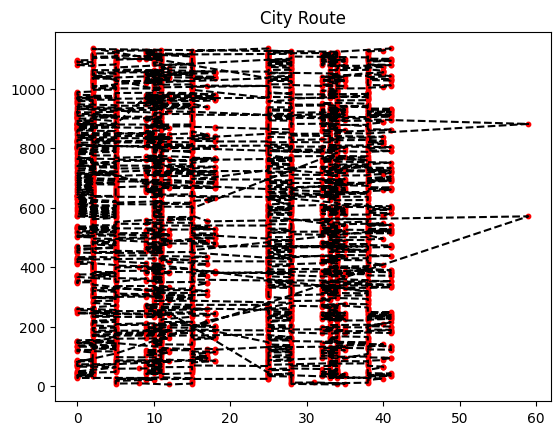

Execution Time: 9.956009864807129
Path: [1273, 1601, 1600, 1025, 887, 889, 1026, 890, 1274, 1602, 1990, 1991, 1992, 1989, 1988, 1986, 1985, 1984, 1983, 1982, 2347, 2348, 2349, 2350, 2591, 2742, 2995, 2994, 2741, 2590, 2740, 2993, 2992, 2739, 2738, 2991, 2990, 2737, 2736, 2989, 2988, 2735, 2734, 2987, 3214, 2589, 2733, 2986, 2985, 2732, 2588, 3213, 2984, 2731, 2587, 2586, 2730, 2983, 3212, 2982, 2729, 2728, 2585, 2981, 3211, 2980, 2727, 2726, 2979, 3315, 3316, 3563, 3564, 3317, 3318, 3565, 3566, 3319, 3567, 3568, 3320, 3321, 3569, 3570, 3322, 3323, 3324, 3325, 3326, 3327, 3328, 2997, 2592, 3215, 3329, 3331, 3332, 3333, 3334, 2999, 2595, 2746, 2594, 2744, 2593, 2353, 2354, 2355, 1994, 1995, 1996, 1997, 1998, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2014, 2368, 2367, 2366, 2365, 2363, 2362, 2361, 2360, 2359, 2358, 2357, 2596, 2749, 3002, 3001, 2748, 2747, 3000, 3336, 3337, 3338, 3005, 2752, 2597, 2751, 3004, 3006, 2753, 2754, 3007, 3008, 2755, 2598, 25

In [10]:
# Step 1
try:
    coord_list = fileloader()
except Exception as e:
    print('예외 발생', e)
    sys.exit()

start_time = time.time()

# Step 2
best_path, best_cost, cost_arr = greedy(coord_list)

print('Execution Time: ' + str(time.time() - start_time))
print('Path: ' + str(best_path.tolist()))
print('Cost: ' + str(best_cost))
